# Estimation of visibility map

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
staircase = pd.read_csv('../writeup/data/main/visibility_map/detection_task_B.csv')

In [3]:
eps = 1e-10

def weibull(c, thres, s, lam):
    return 0.5 + (0.5-lam)*(1.-np.exp(-(c/thres)**s))

def nll_joint(par, ctrst, corr):
    thres_0, thres_1, s, lam = par
    ctrst_0, ctrst_1 = ctrst
    corr_0,  corr_1  = corr
    
    prob_0 = weibull(ctrst_0, thres_0, s, lam)
    prob_1 = weibull(ctrst_1, thres_1, s, lam)
    
    prob_0[prob_0>=1.] = 1.-eps
    prob_0[prob_0<=0]  = eps
    prob_1[prob_1>=1.] = 1.-eps
    prob_1[prob_1<=0]  = eps
    
    sum_ll   = np.sum(np.log(prob_0[corr_0==1])) + np.sum(np.log(1.-prob_0[corr_0==0]))
    sum_ll  += np.sum(np.log(prob_1[corr_1==1])) + np.sum(np.log(1.-prob_1[corr_1==0]))
    return -sum_ll

def smooth(e): return 2. + 2.8*e/(e+0.8)

In [4]:
result = pd.DataFrame()
for i_loc, v_loc in enumerate([2.125,6.375]):
    idx = (staircase.location == v_loc) 
    
    ctrst = [staircase.contrast[idx & (staircase.noise == 0.05)].to_numpy(),
             staircase.contrast[idx & (staircase.noise == 0.20)].to_numpy()]
    corr  = [staircase.correct[idx & (staircase.noise == 0.05)].to_numpy(),
             staircase.correct[idx & (staircase.noise == 0.20)].to_numpy()]
    
    res = minimize(nll_joint, [.5,.5,2.,0.1], 
                   args = (ctrst, corr), 
                   bounds = [[eps, 20.],[eps, 20.],[eps, 20.],[eps, .1]])
    
    result = pd.concat([result, pd.DataFrame({'eccen':[v_loc,v_loc], 
                                              'noise':[0.05,0.2], 
                                              'threshold':[res['x'][0],res['x'][1]],
                                              'smooth':[res['x'][2],res['x'][2]],
                                              'lapse':[res['x'][3],res['x'][3]]})])

In [5]:
result

,eccen,noise,threshold,smooth,lapse
0,2.125,0.05,0.025919,3.776987,0.041768
1,2.125,0.20,0.069310,3.776987,0.041768
0,6.375,0.05,0.037227,3.054385,0.035104
1,6.375,0.20,0.115264,3.054385,0.035104


In [6]:
def simple_regression(x,y):
    cov = np.cov(x,y)
    slope = cov[0,1]/cov[0,0]
    intercept = np.mean(y) - slope*np.mean(x)
    return slope, intercept

In [7]:
# simple_regression([0.05,0.20], [0.025919,0.069310])
# simple_regression([0.05,0.20], [0.037227,0.115264])

eccen  = [2.125, 6.375]
slopes = [0.289320, 0.513627]
inters = [0.011465, 0.011585]

s_slopes, i_slopes = simple_regression(eccen, np.log(slopes))
s_inters, i_inters = simple_regression(eccen, np.log(inters))
s_smooth, i_smooth = simple_regression(eccen, [3.775781, 3.046680])

m_lapse = np.mean(result.lapse)

In [8]:
def threshold(en, eps):
    """ threshold function
    """
    slope     = np.exp(i_slopes+s_slopes*eps)
    intercept = np.exp(i_inters+s_inters*eps)
    
    return np.sqrt(intercept+(en**2)*slope)

def psychometric(c, thres, eps):
    """ psychometric function: using approximation specified in the paper.
    """
    # s = 2.8*eps/(eps+0.8)+2.
    s = i_smooth+s_smooth*eps
    
    # return 0.5 + 0.5*(1.-np.exp(-(c/thres)**s))
    return 0.5 + (0.5-m_lapse)*(1.-np.exp(-(c/thres)**s))

def dprime(c, en, eps):
    """ dprime function
    """
    return np.sqrt(2)*norm.ppf(psychometric(c,threshold(en,eps),eps))

[0.147, 0.156, 0.164, 0.18, 0.194, 0.207]
[0.19, 0.202, 0.213, 0.233, 0.251, 0.269]


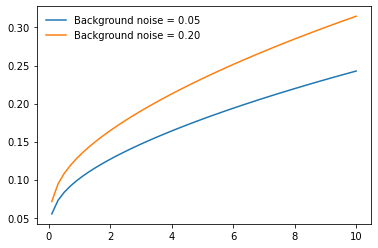

In [9]:
ds  = np.linspace(0.1,10)
lam = 0
def get_center_contrast(ds, en):
    thres = threshold(en, 0)    
    return thres * (np.log(  (lam-0.5) / (lam-1. + norm.cdf(ds / np.sqrt(2)))  ) ** (1./i_smooth))

plt.plot(ds, get_center_contrast(ds, en=0.05), label='Background noise = 0.05')
plt.plot(ds, get_center_contrast(ds, en=0.20), label='Background noise = 0.20')

print([np.round(get_center_contrast(_d, en=0.05), 3) for _d in [3., 3.5, 4., 5., 6., 7.]])
print([np.round(get_center_contrast(_d, en=0.20), 3) for _d in [3., 3.5, 4., 5., 6., 7.]])

plt.legend(frameon=False)
plt.show()